In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install x-transformers
!pip install matplotlib
!pip install einops
!pip install wandb
!pip install scipy
!pip install pandas

from google.colab import drive
drive.mount('/content/drive')

import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.signal import butter, filtfilt
from torch.utils.data import DataLoader
import sys
import pandas as pd

import numpy as np

import re
import pickle

sys.path.append('/content/drive/MyDrive/realistic-imu/src')

from trase_dataset import TraseDataset
from trase import Trase, TraseLoss

if 'ipykernel' in sys.modules:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

data_path = "/content/drive/MyDrive/beyondamass/data/realistic-imu-dataset/"
model_path = "/content/drive/MyDrive/beyondamass/src/weights/trase_wo_total.ptrom"

train_path = os.path.join(data_path, "train.pkl")
dev_path = os.path.join(data_path, "dev.pkl")

identity_collate = lambda batch: batch

train_dataset = TraseDataset(train_path)
dev_dataset = TraseDataset(dev_path)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=identity_collate)
dev_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False, collate_fn=identity_collate)

device = torch.device("cuda")

fs = 60
cutoff =  8
b, a = butter(10, cutoff / (fs / 2), btype='lowpass')

NIMBLE_BODY_NODES_ALL = [
    'pelvis',
    'femur_r',
    'tibia_r',
     'talus_r',
     'calcn_r',
     'toes_r',
     'femur_l',
     'tibia_l',
     'talus_l',
     'calcn_l',
     'toes_l',
     'lumbar_body',
     'thorax',
     'head',
     'scapula_r',
     'humerus_r',
     'ulna_r',
     'radius_r',
     'hand_r',
     'scapula_l',
     'humerus_l',
     'ulna_l',
     'radius_l',
     'hand_l'
]

body_node_to_idx = {node: idx for idx, node in enumerate(NIMBLE_BODY_NODES_ALL)}


Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 109.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 132.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 18.0 MB/s e

In [2]:
np.argmax([dev_dataset[i]["inputs"].shape[1] for i in range(len(dev_dataset))])

np.int64(6)

In [3]:
[dev_dataset[i]["origin"] for i in range(len(dev_dataset))]

['DIPSubject',
 'DIPSubject',
 'DIPSubject',
 'DIPSubject',
 'DIPSubject',
 'UIPSubject',
 'UIPSubject',
 'UIPSubject']

In [4]:
dev_dataset[16]["inputs"].shape
dev_dataset[15]["origin"]

IndexError: list index out of range

In [5]:
D_MODEL = 2048
FEED_FORWARD_DIM = 2048
INPUT_EMBEDDING_DIM = 408
HEADS = 8
NUM_ENCODERS = 6
TOTAL_VAR_WEIGHT = 1e-2

state_dict = torch.load(model_path)

model = Trase(d_model=D_MODEL,
            inp_emb_dim=INPUT_EMBEDDING_DIM,
            device=device,
            num_encoders=NUM_ENCODERS,
            dim_feed_forward=FEED_FORWARD_DIM,
            heads=HEADS).to(device)

orig_state_dict = torch.load(model_path, map_location=device)

stripped_state_dict = {
    k.replace("_orig_mod.", ""): v for k, v in orig_state_dict.items()
}

model.load_state_dict(stripped_state_dict)

criterion = TraseLoss(total_var_weight=TOTAL_VAR_WEIGHT)

model.eval()

Trase(
  (linear1): Linear(in_features=408, out_features=2048, bias=True)
  (layer_norm1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (activation1): GELU(approximate='none')
  (linear2): Linear(in_features=2048, out_features=2048, bias=True)
  (layer_norm2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (activation2): GELU(approximate='none')
  (encoder): Encoder(
    (transformer_encoder): Encoder(
      (layers): ModuleList(
        (0): ModuleList(
          (0): ModuleList(
            (0): LayerNorm(
              (ln): LayerNorm((2048,), eps=1e-05, elementwise_affine=False)
            )
            (1-2): 2 x None
          )
          (1): Attention(
            (to_q): Linear(in_features=2048, out_features=512, bias=False)
            (to_k): Linear(in_features=2048, out_features=512, bias=False)
            (to_v): Linear(in_features=2048, out_features=512, bias=False)
            (split_q_heads): Rearrange('b n (h d) -> b h n d', h=8)
            (sp

# Just checking if I uploaded the correct model

In [6]:
curr_loss = 0

with torch.no_grad():
  for data in dev_loader:
    data = data[0]
    mocap_data = data["inputs"]
    real_acc = data["accelerations_output"]
    real_angular_vel = data["angular_velocities_output"] if data["angular_velocities_output"] is not None else None
    mask = data["output_mask"].T
    weights = data["weights"].T.repeat_interleave(3, dim=0)

    kinematics, acc_output, acc_std, gyro_output, gyro_std = model(mocap_data)

    loss = criterion(kinematics=kinematics * mask * weights,
                    acc_mean = acc_output * mask * weights,
                    acc_std = acc_std * weights,
                    real_acc = real_acc * mask * weights,
                    gyro_mean = gyro_output,
                    gyro_std = gyro_std,
                    real_gyro = real_angular_vel,
                    include_gyro = real_angular_vel is not None)


    curr_loss += loss.item()

print(curr_loss / len(dev_loader))

-3.929862469434738


## Are the accelerations and predicted spring kinematics doing what I designed them to do?


In [28]:
def plot_time_series(series, title="Time Series Plot", xlabel="Time", ylabel="Value", figsize=(12, 6)):
    plt.figure(figsize=figsize)
    plt.plot(series, label="Time Series", color="blue", linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(alpha=0.3, linestyle='--')
    # plt.ylim(-10, 10)
    plt.tight_layout()
    plt.legend(fontsize=12)
    plt.show()

def plot_time_series_overlay(series_list, labels=None, title="Overlayed Time Series Plot",
                              xlabel="Time", ylabel="Value", figsize=(12, 6),
                              colors=None, alpha=0.2, linewidth=2):
    """
    Plots multiple time series with transparency to visualize overlaps.

    Args:
        series_list (list of array-like): List of time series arrays to plot.
        labels (list of str, optional): Labels for each series.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
        figsize (tuple): Figure size.
        colors (list of str, optional): List of colors for each series.
        alpha (float): Transparency of each time series line.
        linewidth (float): Width of the lines.
    """
    plt.figure(figsize=figsize)

    n = len(series_list)
    time = np.arange(len(series_list[0]))  # Assumes all series are same length

    for i, series in enumerate(series_list):
        color = colors[i] if colors else None
        label = labels[i] if labels else None
        plt.plot(time, series, label=label, color=color, linewidth=linewidth, alpha=alpha)

    if labels:
        plt.legend(fontsize=12)

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

example_data = dev_dataset[1]
part = "head"
time_range = slice(2000, 2500)

mocap_data = example_data["inputs"]
real_acc = example_data["accelerations_output"]
real_angular_vel = example_data["angular_velocities_output"] if example_data["angular_velocities_output"] is not None else None
mask = example_data["output_mask"].T
weights = data["weights"].T.repeat_interleave(3, dim=0)

kinematics, acc_output, acc_std, gyro_output, gyro_std = model(mocap_data)

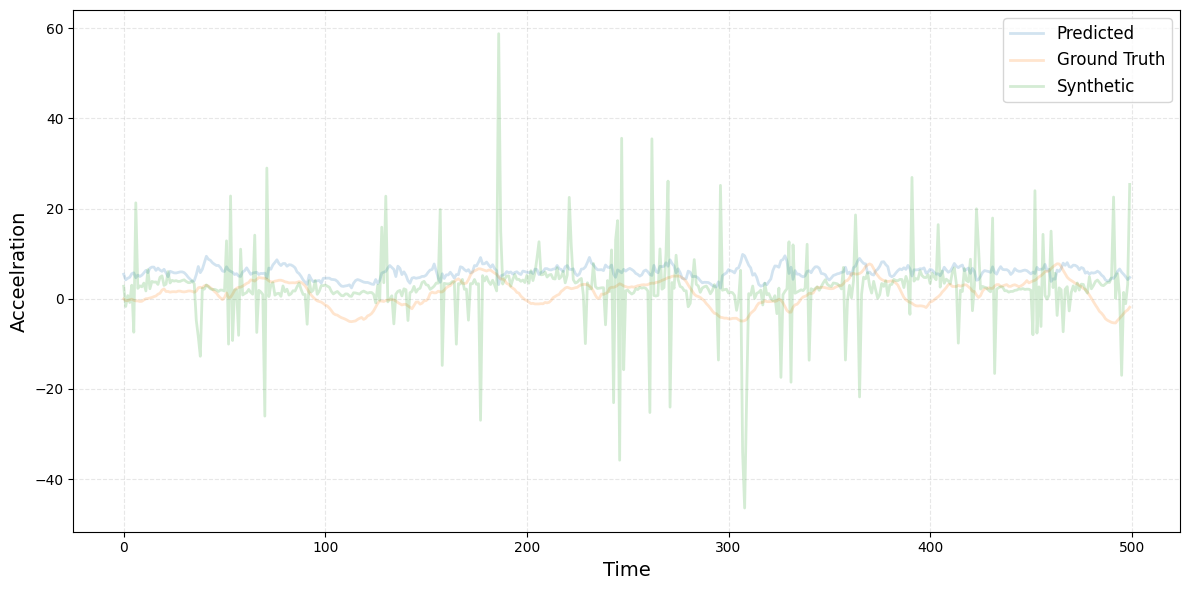

In [32]:
axis_index = 1
acc_pred_vs_real = [acc_output.detach().cpu()[body_node_to_idx[part] * 3 + axis_index, time_range] + kinematics.detach().cpu()[body_node_to_idx[part] * 3 + axis_index, time_range],
                    real_acc.detach().cpu()[body_node_to_idx[part] * 3 + axis_index, time_range],
                    mocap_data.detach().cpu()[0, time_range, body_node_to_idx[part] * 17 + axis_index]
                    ]
plot_time_series_overlay(acc_pred_vs_real, labels=["Predicted", "Ground Truth", "Synthetic"], ylabel="Acceelration")

In [9]:
# prompt: Do the same thing that I did to plot the overlay graphs here using the same function but with the gyro output

gyro_pred_vs_real = [gyro_output.detach().cpu()[body_node_to_idx[part] * 3 + 1, time_range],
                     real_angular_vel.detach().cpu()[body_node_to_idx[part] * 3 + 1, time_range],
                     mocap_data.detach().cpu()[0, time_range, body_node_to_idx[part] * 17 + 1 + 3]
                     ]
plot_time_series_overlay(gyro_pred_vs_real, labels=["Predicted", "Ground Truth", "Synthetic"], ylabel="Angular Velocity")


AttributeError: 'NoneType' object has no attribute 'detach'

# Trase Model Performance

In [25]:
acc_mse = 0
gyro_mse = 0
acc_exps = 0
gyro_exps = 0

with torch.no_grad():
  for data in dev_loader:
    data = data[0]
    mocap_data = data["inputs"]
    real_acc = data["accelerations_output"]
    real_angular_vel = data["angular_velocities_output"] if data["angular_velocities_output"] is not None else None
    mask = data["output_mask"].T
    weights = data["weights"].T.repeat_interleave(3, dim=0)

    kinematics, acc_output, acc_std, gyro_output, gyro_std = model(mocap_data)

    acc_pred = (acc_output.detach() + kinematics.detach()) * mask
    acc_pred = acc_pred.cpu().numpy()

    real_acc = real_acc * mask
    real_acc = real_acc.cpu().numpy()

    acc_diff = acc_pred - real_acc
    acc_sq = acc_diff ** 2

    acc_exps += acc_sq.size
    acc_mse += np.sum(acc_sq)

    if real_angular_vel is not None:
        gyro_pred = gyro_output.detach().cpu().numpy()
        real_gyro = real_angular_vel.detach().cpu().numpy()

        diff = gyro_pred - real_gyro
        sq = diff ** 2

        gyro_exps += sq.size

        gyro_mse += np.sum(sq)

  acc_mse /= acc_exps
  gyro_mse /= gyro_exps

  print(f"Acceleration MSE {acc_mse}")
  print(f"Angular Velocity MSE {gyro_mse}")


ZeroDivisionError: division by zero

# Nothing but a central difference

In [ ]:
acc_mse = 0
gyro_mse = 0
acc_exps = 0
gyro_exps = 0

with torch.no_grad():
  for data in dev_loader:
    data = data[0]
    mocap_data = data["inputs"]
    real_acc = data["accelerations_output"]
    real_angular_vel = data["angular_velocities_output"] if data["angular_velocities_output"] is not None else None
    mask = data["output_mask"].T
    weights = data["weights"].T.repeat_interleave(3, dim=0)


    acc_pred = mocap_data[0].reshape(-1, 24, 17)[:, :, 1:4].reshape(-1, 72).T
    acc_pred = acc_pred.cpu().numpy()

    real_acc = real_acc * mask
    real_acc = real_acc.cpu().numpy()

    acc_diff = acc_pred - real_acc
    acc_sq = acc_diff ** 2

    acc_exps += acc_sq.size
    acc_mse += np.sum(acc_sq)

    if real_angular_vel is not None:
        gyro_pred = mocap_data[0].reshape(-1, 24, 17)[:, :, 4:7].reshape(-1, 72).T.detach().cpu().numpy()
        real_gyro = real_angular_vel.detach().cpu().numpy()

        diff = gyro_pred - real_gyro
        sq = diff ** 2

        gyro_exps += sq.size

        gyro_mse += np.sum(sq)

  acc_mse /= acc_exps
  gyro_mse /= gyro_exps

  print(f"Acceleration MSE {acc_mse}")
  print(f"Angular Velocity MSE {gyro_mse}")

# Butterworth Filter

In [ ]:
acc_mse = 0
gyro_mse = 0
acc_exps = 0
gyro_exps = 0

with torch.no_grad():
  for data in dev_loader:
    data = data[0]
    mocap_data = data["inputs"]
    real_acc = data["accelerations_output"]
    real_angular_vel = data["angular_velocities_output"] if data["angular_velocities_output"] is not None else None
    mask = data["output_mask"].T
    weights = data["weights"].T.repeat_interleave(3, dim=0)


    acc_pred = filtfilt(b, a, mocap_data[0].reshape(-1, 24, 17)[:, :, 1:4].reshape(-1, 72).T.detach().cpu().numpy())

    real_acc = real_acc * mask
    real_acc = filtfilt(b, a, real_acc.cpu().numpy())

    acc_diff = acc_pred - real_acc
    acc_sq = acc_diff ** 2

    acc_exps += acc_sq.size
    acc_mse += np.sum(acc_sq)

    if real_angular_vel is not None:
        gyro_pred = filtfilt(b, a, mocap_data[0].reshape(-1, 24, 17)[:, :, 4:7].reshape(-1, 72).T.detach().cpu().numpy())
        real_gyro = filtfilt(b, a, real_angular_vel.detach().cpu().numpy())

        diff = gyro_pred - real_gyro
        sq = diff ** 2

        gyro_exps += sq.size

        gyro_mse += np.sum(sq)

  acc_mse /= acc_exps
  gyro_mse /= gyro_exps

  print(f"Acceleration MSE {acc_mse}")
  print(f"Angular Velocity MSE {gyro_mse}")

# Exponential Moving average and Savitsky Golay Filter

In [ ]:
# prompt: Do the same thing as above for a savitsky golay filter and and an exponential moving average with a window of 11 to calculate the mean squared error. Be sure to apply the filter to both synthetic and real data

from scipy.signal import savgol_filter

def exponential_moving_average(data, window_size):
  """Calculates the Exponential Moving Average of a time series."""
  ema = np.zeros_like(data)
  alpha = 2 / (window_size + 1)
  ema[0] = data[0]
  for i in range(1, len(data)):
    ema[i] = alpha * data[i] + (1 - alpha) * ema[i - 1]
  return ema

# Exponential Moving Average and Savitsky Golay Filter
acc_mse_ema = 0
gyro_mse_ema = 0
acc_exps_ema = 0
gyro_exps_ema = 0

acc_mse_savgol = 0
gyro_mse_savgol = 0
acc_exps_savgol = 0
gyro_exps_savgol = 0

window_size = 11
savgol_window = 11 # Must be odd
savgol_polyorder = 2

with torch.no_grad():
  for data in dev_loader:
    data = data[0]
    mocap_data = data["inputs"]
    real_acc = data["accelerations_output"]
    real_angular_vel = data["angular_velocities_output"] if data["angular_velocities_output"] is not None else None
    mask = data["output_mask"].T
    weights = data["weights"].T.repeat_interleave(3, dim=0)

    # Apply EMA to synthetic data (from mocap_data)
    synthetic_acc = mocap_data[0].reshape(-1, 24, 17)[:, :, 1:4].reshape(-1, 72).T.detach().cpu().numpy()
    ema_acc_pred = np.apply_along_axis(lambda row: exponential_moving_average(row, window_size), axis=1, arr=synthetic_acc)

    # Apply EMA to real data
    real_acc_masked = real_acc * mask
    real_acc_masked_np = real_acc_masked.cpu().numpy()
    # We need to handle the masked values correctly for EMA. A simple approach
    # is to only calculate EMA for unmasked sections, but for simplicity here
    # we'll apply to the potentially masked data. A more sophisticated approach
    # might involve splitting into unmasked segments.
    ema_real_acc = np.apply_along_axis(lambda row: exponential_moving_average(row, window_size), axis=1, arr=real_acc_masked_np)

    # Calculate MSE for EMA
    acc_diff_ema = ema_acc_pred - ema_real_acc
    acc_sq_ema = acc_diff_ema ** 2

    acc_exps_ema += acc_sq_ema.size
    acc_mse_ema += np.sum(acc_sq_ema)

    if real_angular_vel is not None:
        synthetic_gyro = mocap_data[0].reshape(-1, 24, 17)[:, :, 4:7].reshape(-1, 72).T.detach().cpu().numpy()
        ema_gyro_pred = np.apply_along_axis(lambda row: exponential_moving_average(row, window_size), axis=1, arr=synthetic_gyro)

        real_gyro_np = real_angular_vel.detach().cpu().numpy()
        ema_real_gyro = np.apply_along_axis(lambda row: exponential_moving_average(row, window_size), axis=1, arr=real_gyro_np)

        diff_ema = ema_gyro_pred - ema_real_gyro
        sq_ema = diff_ema ** 2

        gyro_exps_ema += sq_ema.size
        gyro_mse_ema += np.sum(sq_ema)

    # Apply Savitsky Golay to synthetic data
    savgol_acc_pred = savgol_filter(synthetic_acc, savgol_window, savgol_polyorder, axis=1)

    # Apply Savitsky Golay to real data
    # Savgol_filter handles NaN values if present, which might occur due to masking.
    savgol_real_acc = savgol_filter(real_acc_masked_np, savgol_window, savgol_polyorder, axis=1)

    # Calculate MSE for Savitsky Golay
    acc_diff_savgol = savgol_acc_pred - savgol_real_acc
    acc_sq_savgol = acc_diff_savgol ** 2

    acc_exps_savgol += acc_sq_savgol.size
    acc_mse_savgol += np.sum(acc_sq_savgol)

    if real_angular_vel is not None:
        savgol_gyro_pred = savgol_filter(synthetic_gyro, savgol_window, savgol_polyorder, axis=1)
        savgol_real_gyro = savgol_filter(real_gyro_np, savgol_window, savgol_polyorder, axis=1)

        diff_savgol = savgol_gyro_pred - savgol_real_gyro
        sq_savgol = diff_savgol ** 2

        gyro_exps_savgol += sq_savgol.size
        gyro_mse_savgol += np.sum(sq_savgol)

acc_mse_ema /= acc_exps_ema
gyro_mse_ema /= gyro_exps_ema

acc_mse_savgol /= acc_exps_savgol
gyro_mse_savgol /= gyro_exps_savgol


print(f"EMA Acceleration MSE {acc_mse_ema}")
print(f"EMA Angular Velocity MSE {gyro_mse_ema}")
print(f"Savitsky Golay Acceleration MSE {acc_mse_savgol}")
print(f"Savitsky Golay Angular Velocity MSE {gyro_mse_savgol}")

In [ ]:
# prompt: get the correlation coefficients for the gyro to real and acc pred to real acc

from scipy.stats import pearsonr

# Assuming acc_pred_vs_real and gyro_pred_vs_real are lists of numpy arrays or tensors
# and the first element is the predicted series, the second is the real series.

# Calculate correlation for acc pred vs real acc
acc_pred = acc_pred_vs_real[0].squeeze() # Ensure 1D
real_acc_series = acc_pred_vs_real[1].squeeze() # Ensure 1D

# Ensure both series are the same length
min_len = min(len(acc_pred), len(real_acc_series))
acc_pred = acc_pred[:min_len]
real_acc_series = real_acc_series[:min_len]


# Handle potential NaN or inf values
valid_indices_acc = np.isfinite(acc_pred) & np.isfinite(real_acc_series)
acc_pred_valid = acc_pred[valid_indices_acc]
real_acc_series_valid = real_acc_series[valid_indices_acc]

if len(acc_pred_valid) > 1:
    correlation_acc, _ = pearsonr(acc_pred_valid, real_acc_series_valid)
    print(f"Correlation coefficient (Acc Pred vs Real Acc): {correlation_acc}")
else:
    print("Cannot compute correlation for Acc Pred vs Real Acc: Not enough valid data points.")


# Calculate correlation for gyro pred vs real gyro
if real_angular_vel is not None:
    gyro_pred = gyro_pred_vs_real[0].squeeze() # Ensure 1D
    real_gyro_series = gyro_pred_vs_real[1].squeeze() # Ensure 1D

    # Ensure both series are the same length
    min_len = min(len(gyro_pred), len(real_gyro_series))
    gyro_pred = gyro_pred[:min_len]
    real_gyro_series = real_gyro_series[:min_len]

    # Handle potential NaN or inf values
    valid_indices_gyro = np.isfinite(gyro_pred) & np.isfinite(real_gyro_series)
    gyro_pred_valid = gyro_pred[valid_indices_gyro]
    real_gyro_series_valid = real_gyro_series[valid_indices_gyro]

    if len(gyro_pred_valid) > 1:
        correlation_gyro, _ = pearsonr(gyro_pred_valid, real_gyro_series_valid)
        print(f"Correlation coefficient (Gyro Pred vs Real Gyro): {correlation_gyro}")
    else:
         print("Cannot compute correlation for Gyro Pred vs Real Gyro: Not enough valid data points.")
else:
    print("Real angular velocity data is not available, cannot compute gyro correlation.")



In [ ]:
# prompt: print the mean of gyro std and acc std

mean_acc_std = torch.mean(acc_std)
mean_gyro_std = torch.mean(gyro_std)

print(f"Mean of acceleration std: {mean_acc_std.item()}")
print(f"Mean of gyroscope std: {mean_gyro_std.item()}")
